In [21]:
import numpy as np
from matplotlib import pyplot as plt
import pickle, os
import pandas as pd
from tqdm import tqdm 

## Load Important Function

In [22]:
class Data:
    def __init__(self, array_list):
        self.array_list = array_list

    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self.array_list, f)

    @classmethod
    def load(cls, filename):
        with open(filename, 'rb') as f:
            array_list = pickle.load(f)
        return cls(array_list)

In [23]:
def omega2cistrans(omega):
    """Converts a sequence of float omega angles (in degrees) to an array of ints: 0 cis and 1 trans."""
    
    shifted_omega = (omega + 90.0) % 360.0 - 90.0 # shift into (-90, 270) range to avoid periodic boundaries
    
    cistrans = np.where(shifted_omega > 90.0, 1, 0).astype(int)
    return cistrans

In [24]:
def state_to_index_vectorized(all_state):
    """
    Converts a (N, M, 2) array of states into (N, M) indices in [0..7].

    Assumes:
      - The first entry is a binary bit (0 or 1).
      - The second entry is an integer in [0..3].
      - If any of the two entries is NaN, the output is NaN for that row.

    Parameters
    ----------
    all_state : array-like
        An array of shape (N, M, 2).

    Returns
    -------
    indexed_states : ndarray
        A float array of shape (N, M). Valid entries are in the range [0..7].
        Entries with NaNs in the input remain NaN.
    """
    all_state_array = np.array(all_state, dtype=float)

    if all_state_array.ndim != 3 or all_state_array.shape[-1] != 2:
        raise ValueError(f"Unexpected shape: {all_state_array.shape}, expected (N, M, 2).")

    # NaN handling
    nan_mask = np.isnan(all_state_array).any(axis=-1)
    valid_mask = ~nan_mask

    # Prepare output
    indexed_states = np.full(all_state_array.shape[:-1], np.nan, dtype=float)

    # Compute index: 4 * binary_bit + discrete_value
    weights = np.array([4, 1], dtype=float)
    valid_data = all_state_array[valid_mask]
    results = valid_data @ weights

    indexed_states[valid_mask] = results

    return indexed_states

In [25]:
def index_to_state(index):
    """
    Converts an index (0-7) into a (2,) array:
      - The first element is a binary bit (0 or 1)
      - The second element is an integer in [0..3]

    This reverses the mapping from:
        index = 4 * binary_bit + value_in_0_to_3

    Parameters
    ----------
    index : int
        Integer in [0, 7]

    Returns
    -------
    state : np.ndarray
        Array of shape (2,) — [binary_bit, value]
    """
    if not (0 <= index < 8):
        raise ValueError(f"Index out of range: {index}. Expected 0–7.")

    value = index % 4
    binary_bit = index // 4

    return np.array([binary_bit, value], dtype=int)


In [26]:
import numpy as np
from tqdm import tqdm

def calculate_conform_p(trajs, conform_num):
    """
    Calculates the cumulative average population of each conformational state over time,
    excluding NaN values in the trajectory.

    Parameters
    ----------
    trajs : np.ndarray
        A 1D array of shape (timesteps,), where each value is either an integer in 
        [0, conform_num-1] or NaN (for missing data).

    conform_num : int
        The total number of conformational states.

    Returns
    -------
    conform_population : np.ndarray
        Array of shape (conform_num, valid_timesteps) — cumulative average population per conformation.
    """
    trajs = np.asarray(trajs)

    # Only keep valid time steps (non-NaN)
    valid_mask = ~np.isnan(trajs)
    trajs_clean = trajs[valid_mask]
    n_time = trajs_clean.shape[0]

    conform_population = np.zeros((conform_num, n_time), dtype=float)

    for conform_state in range(conform_num):
        match_mask = (trajs_clean == conform_state).astype(float)  # shape: (n_time,)

        cumulative_counts = np.cumsum(match_mask)  # shape: (n_time,)
        time_steps = np.arange(1, n_time + 1)      # shape: (n_time,)

        cumulative_proportions = cumulative_counts / time_steps  # shape: (n_time,)
        conform_population[conform_state] = cumulative_proportions

    #print('Conform population shape:', conform_population.shape)

    return conform_population


## The Trans Population overtime Plot

In [27]:
save_dir = 'omega_data'
all_omega = Data.load(f"{save_dir}/all_omega.pkl").array_list  # This is an (85, x, 3) array
# Convert each array in the list to float
all_omega = [arr.astype(float) for arr in all_omega]

# Apply omega2cistrans() to each array in all_omega
all_cistrans = [omega2cistrans(arr) for arr in all_omega]

# Print shape of the first converted array for verification
print(f"First array shape after conversion: {all_cistrans[0].shape}")

First array shape after conversion: (12002, 3)


In [28]:
# Find the minimum x-dimension across all arrays
min_x = min(arr.shape[0] for arr in all_cistrans)

print(f"Shortest x in all_cistrans: {min_x}")

Shortest x in all_cistrans: 5002


In [29]:
# Define paths
traj_path = '../PROJ12462traj'
log_path = '../log'

all_state = []

# Iterate over RUN and CLONE indices
for r in range(2, 3):  # Only r=2 for now
    for c in range(100):  # Iterate over c=0 to c=99
        csv_log = f"{log_path}/RUN{r}_CLONE{c}_log.csv"
        input_xtc_file = f"{traj_path}/r{r}c{c}_inte.xtc"

        # Corrected condition: Check if either file is missing
        if not os.path.exists(csv_log) or not os.path.exists(input_xtc_file):
            print(f"Missing file(s): {input_xtc_file if not os.path.exists(input_xtc_file) else ''}")
            print(f"Missing log file(s): {csv_log if not os.path.exists(csv_log) else ''}")
            continue

        # Load log and convert states
        df_log = pd.read_csv(csv_log, header=0)
        log = df_log.iloc[:, 0].values  # Convert to NumPy array
        all_state.append(log)

all_state

Missing file(s): ../PROJ12462traj/r2c26_inte.xtc
Missing log file(s): 
Missing file(s): ../PROJ12462traj/r2c27_inte.xtc
Missing log file(s): 
Missing file(s): ../PROJ12462traj/r2c46_inte.xtc
Missing log file(s): 
Missing file(s): ../PROJ12462traj/r2c77_inte.xtc
Missing log file(s): 
Missing file(s): ../PROJ12462traj/r2c91_inte.xtc
Missing log file(s): 
Missing file(s): ../PROJ12462traj/r2c99_inte.xtc
Missing log file(s): ../log/RUN2_CLONE99_log.csv


[array([0, 2, 1, ..., 0, 2, 1]),
 array([0, 1, 3, ..., 1, 0, 1]),
 array([0, 1, 3, ..., 1, 2, 0]),
 array([0, 2, 0, ..., 2, 3, 1]),
 array([0, 2, 1, ..., 3, 2, 1]),
 array([0, 2, 1, ..., 0, 2, 2]),
 array([0, 2, 1, ..., 0, 1, 0]),
 array([0, 3, 2, ..., 0, 2, 1]),
 array([0, 1, 3, ..., 0, 0, 0]),
 array([0, 3, 0, ..., 0, 2, 2]),
 array([0, 2, 1, ..., 0, 1, 1]),
 array([0, 2, 0, ..., 2, 2, 3]),
 array([0, 2, 3, ..., 3, 3, 2]),
 array([0, 2, 2, ..., 1, 0, 0]),
 array([0, 3, 2, ..., 3, 2, 0]),
 array([0, 1, 3, ..., 0, 2, 2]),
 array([0, 2, 3, ..., 1, 1, 2]),
 array([0, 2, 1, ..., 2, 3, 2]),
 array([0, 2, 0, ..., 3, 3, 0]),
 array([0, 1, 3, ..., 3, 3, 3]),
 array([0, 1, 3, ..., 1, 2, 3]),
 array([0, 2, 1, ..., 0, 2, 0]),
 array([0, 3, 0, ..., 1, 2, 2]),
 array([0, 1, 1, ..., 3, 3, 3]),
 array([0, 1, 0, ..., 2, 3, 2]),
 array([0, 1, 1, ..., 0, 1, 0]),
 array([0, 2, 3, ..., 1, 0, 0]),
 array([0, 1, 1, ..., 3, 3, 3]),
 array([0, 2, 2, ..., 0, 1, 1]),
 array([0, 3, 0, ..., 3, 1, 2]),
 array([0,

In [30]:
import numpy as np

unique_states = np.unique(all_state[9])
print(unique_states)


[0 1 2 3]


## Create a new data with 85, x, 4 (binary cis/trans state + lambda state)

In [31]:
# Assuming all_cistrans and all_state are lists of numpy arrays
new_all = []

for i in range(len(all_cistrans)):  # Loop over 85 trajectories
    x_len = all_cistrans[i].shape[0]  # Get the x dimension from all_cistrans

    # Trim all_state[i] to match the first x_len frames
    state_trimmed = all_state[i][:x_len]  # Ensure same length along x

    # Reshape state to (x, 1) if necessary
    state_trimmed = state_trimmed.reshape(-1, 1)  # Ensure shape (x, 1)

    # Concatenate along the last axis to get (x, 4)
    combined = np.concatenate((all_cistrans[i], state_trimmed), axis=1)

    # Append to new list
    new_all.append(combined)

new_all[4]

array([[1, 1, 1, 0],
       [1, 0, 0, 2],
       [1, 0, 1, 1],
       ...,
       [1, 0, 1, 2],
       [1, 0, 1, 1],
       [1, 0, 1, 1]])

## Make a whole np traj.shape (85, 37002, 4) with nan, and separa them into 3 res, make it (3, 85, 37002, 2)

In [32]:
ntraj = len(new_all)
print(ntraj)

# Find the longest traj
maxlength = max( [ len(new_all[i]) for i in range(ntraj) ])
print('maxlength', maxlength)

# Make an array to store all the trajectories
traj = np.nan * np.ones( (ntraj, maxlength, 4) )

for i in range(ntraj):
    n = len(new_all[i])
    traj[i, 0:n, :] = new_all[i]

traj # (85, 37002, 4)

94
maxlength 91002


array([[[ 1.,  1.,  1.,  0.],
        [ 0.,  1.,  1.,  2.],
        [ 0.,  1.,  1.,  1.],
        ...,
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]],

       [[ 1.,  1.,  1.,  0.],
        [ 1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  3.],
        ...,
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]],

       [[ 1.,  1.,  1.,  0.],
        [ 1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  3.],
        ...,
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]],

       ...,

       [[ 1.,  1.,  1.,  0.],
        [ 1.,  1.,  1.,  2.],
        [ 1.,  1.,  1.,  3.],
        ...,
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]],

       [[ 1.,  1.,  1.,  0.],
        [ 0.,  1.,  1.,  0.],
        [ 0.,  1.,  1.,  2.],
        ...,
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]],

       [[ 1.

In [33]:
res_num = 3
res_all_traj = []
for res in range(res_num):
    res_traj = traj[:, :, [res, 3]]
    res_all_traj.append(res_traj)

res_all_traj = np.array(res_all_traj)
res_all_traj.shape

(3, 94, 91002, 2)

In [34]:
res_all_traj_indexed = []

for res in res_all_traj:
    res_traj_indexed = state_to_index_vectorized(res)
    res_all_traj_indexed.append(res_traj_indexed)

res_all_traj_indexed = np.array(res_all_traj_indexed)
res_all_traj_indexed.shape

(3, 94, 91002)

(0.0, 0.3)

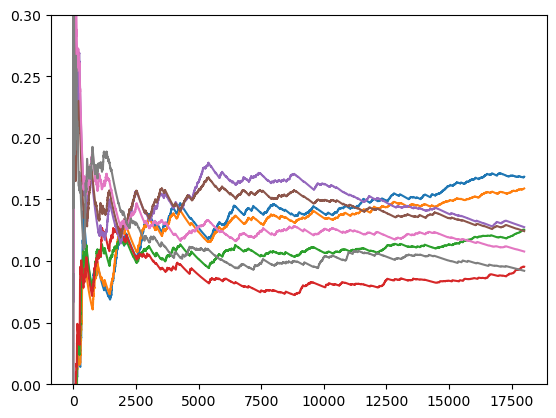

In [35]:
res_all_traj_indexed[1][1].shape
conform_num = 8
conform_p = calculate_conform_p(res_all_traj_indexed[1][1], conform_num)

plt.plot(conform_p.T)
plt.ylim(0, 0.3)

In [38]:
res_num = res_all_traj_indexed.shape[0]
ntraj = res_all_traj_indexed.shape[1]
conform_num = 8

all_conform_populations = []

for res in range(res_num):
    res_conform_populations = []
    for i in range(ntraj):
        traj = res_all_traj_indexed[res][i]
        conform_p = calculate_conform_p(traj, conform_num)
        res_conform_populations.append(conform_p)
    all_conform_populations.append(res_conform_populations)

# Find the longest trajectory (in terms of time steps)
maxlength = max([all_conform_populations[0][i].shape[1] for i in range(ntraj)])
print('maxlength', maxlength)

# Make an array to store all the conformational populations with padding
all_conform_p = np.full((res_num, ntraj, conform_num, maxlength), np.nan) #(3, 94, 8, x)

for res in range(res_num):
    for i in range(ntraj):
        conform_p = all_conform_populations[res][i]
        time_len = conform_p.shape[1]
        all_conform_p[res, i, :, :time_len] = conform_p
    print('all_conform_p.shape', all_conform_p.shape)


all_thermal_conform_mean = np.nanmean(all_conform_p, axis=1)
all_thermal_conform_std = np.nanstd(all_conform_p, axis=1)
all_thermal_conform_mean.shape

maxlength 91002
all_conform_p.shape (3, 94, 8, 91002)
all_conform_p.shape (3, 94, 8, 91002)
all_conform_p.shape (3, 94, 8, 91002)


(3, 8, 91002)

In [41]:
all_thermal_conform_mean[0, :, 1000]

array([0.07449997, 0.07090782, 0.06999384, 0.07828342, 0.17860863,
       0.17213637, 0.17387931, 0.18169065])

In [58]:
## Reshape the traj into (res_num, thermal_num, conform_num, time) (3, 4, 2, x)

thermal_num = 4
conform_num = 2 # cis and trans 
cis_Ind = np.arange(0, 8, 4)
res_num = all_thermal_conform_mean.shape[0]
time_len = all_thermal_conform_mean.shape[2] 

# Preallocate arrays
reshaped_mean = np.full((res_num, thermal_num, conform_num, time_len), np.nan) #(3, 4, 2, x)
reshaped_std = np.full((res_num, thermal_num, conform_num, time_len), np.nan) #(3, 4, 2, x)

for res in range(res_num):
    for thermal in range(thermal_num):
        reshaped_mean[res][thermal] = all_thermal_conform_mean[res][cis_Ind + thermal] #(3)(4, 2, x)
        reshaped_std[res][thermal] = all_thermal_conform_std[res][cis_Ind + thermal]

        reshaped_mean[res][thermal] /= np.nansum(reshaped_mean[res][thermal], axis=0)

# Normalize over conformers at each time point per thermal group
reshaped_mean[0][0][1, 10000] # [res][thermal_num] 

/var/folders/2g/yfyfpy7d3n3fwl_23ytkftvm0000gn/T/ipykernel_30836/2105336808.py:18: RuntimeWarning: invalid value encountered in divide
  reshaped_mean[res][thermal] /= np.nansum(reshaped_mean[res][thermal], axis=0)


0.7111504239605477

In [52]:
population_result = [reshaped_mean, reshaped_std]
os.makedirs('population_data', exist_ok=True)

data_instance = Data(population_result)
data_instance.save("population_data/population_res.pkl")

## Plot for each Res

In [66]:
mean = reshaped_mean[res, thermal, 1,  :]
time = np.arange(reshaped_mean.shape[3]) #(3, 4, 2, x)
time.shape
mean.shape

(91002,)

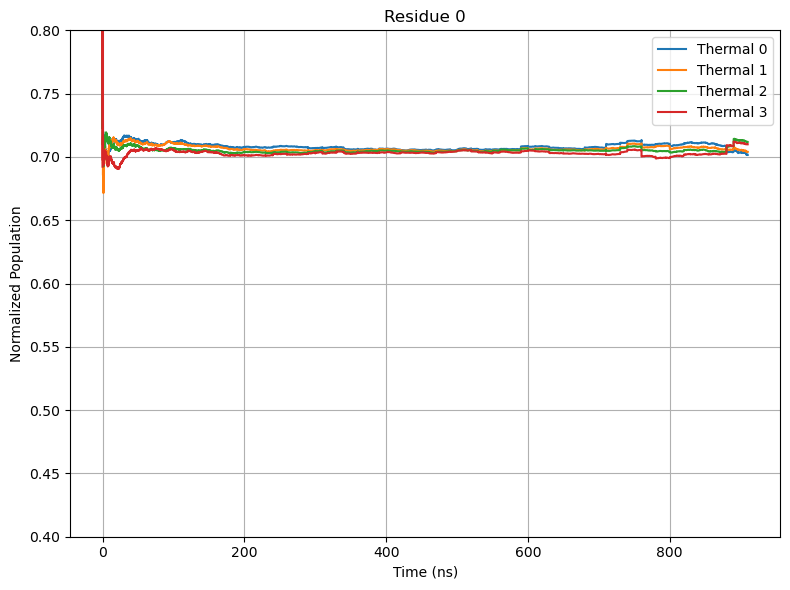

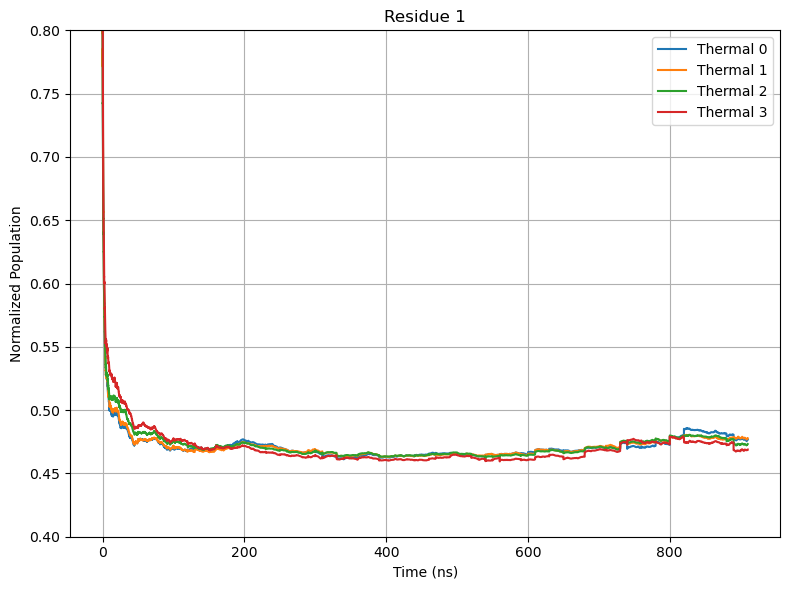

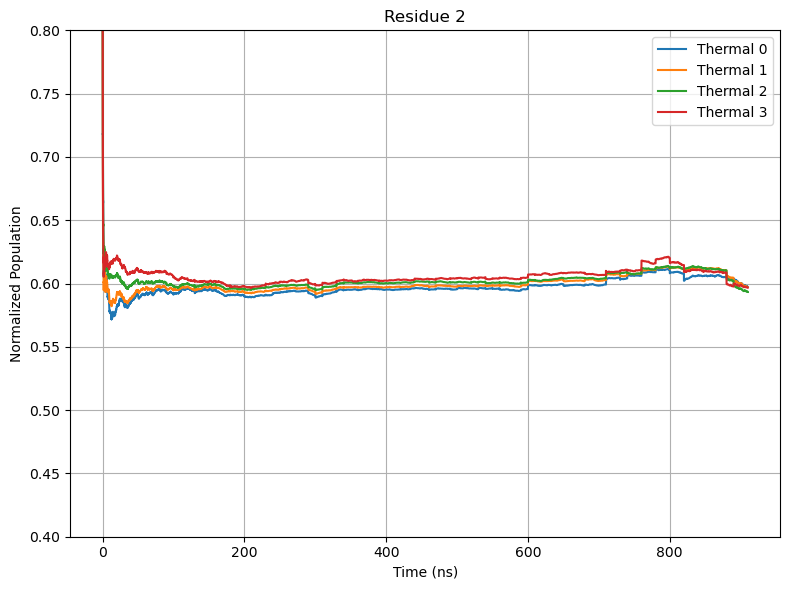

In [71]:
dt_in_ns = 0.01  # 10 ps = 0.01 ns
thermal_num = 4
time = np.arange(reshaped_mean.shape[3]) #(3, 4, 2, x)
time_ns = time * dt_in_ns  # Convert to ns

for res in range(res_num):
    plt.figure(figsize=(8, 6))
    for thermal in range(thermal_num):
        mean = reshaped_mean[res, thermal, 1,  :] # Only plot trans 
        rmsd = reshaped_std[res, thermal, 1,  :] # Only plot trans 

        # Plot mean line
        plt.plot(time_ns, mean, label=f'Thermal {thermal}')
        # Plot shaded region using time_ns
        #plt.fill_between(time_ns, mean - rmsd, mean + rmsd, alpha=0.3)

    plt.ylim(0.4, 0.8)
    plt.xlabel("Time (ns)")
    plt.ylabel("Normalized Population")
    plt.title(f"Residue {res}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## Plot for each thermal state

In [ ]:
## Load in the refer values calculated by MSM

df_stationary_p = pd.read_csv("autocoorel_data/trans_population_at_lagtime.csv")
#print(df_stationary_p)
    
# Pivot the DataFrame to reshape it
pivot_mean = df_stationary_p.pivot(index='state', columns='res', values='mean')
pivot_std = df_stationary_p.pivot(index='state', columns='res', values='std')

# Convert to NumPy arrays
trans_refer = pivot_mean.to_numpy()  # shape (6, 3) state, residues 
trans_refer_err = pivot_std.to_numpy()  # shape (6, 3)
trans_refer.shape

(4, 3)

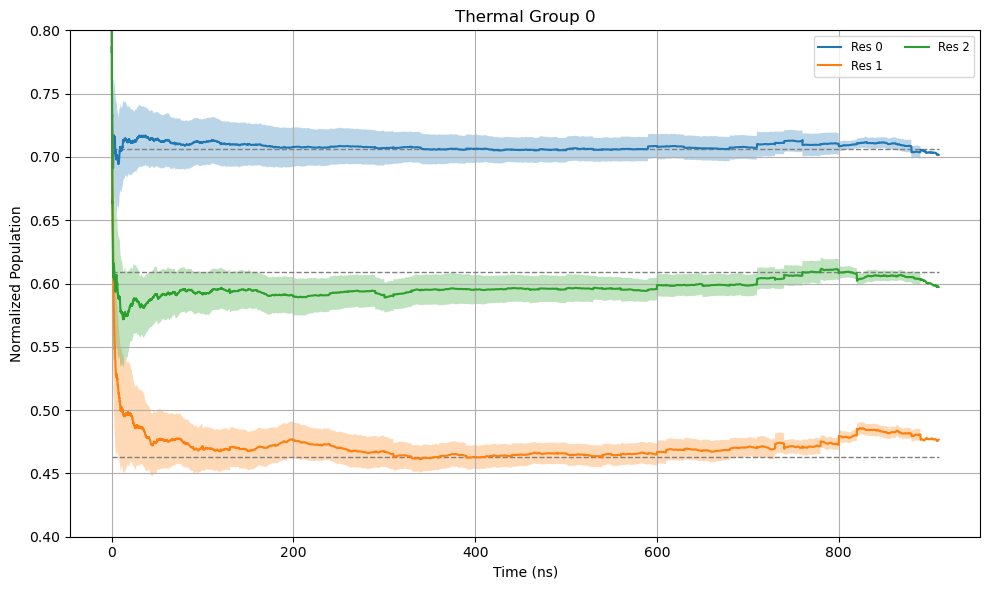

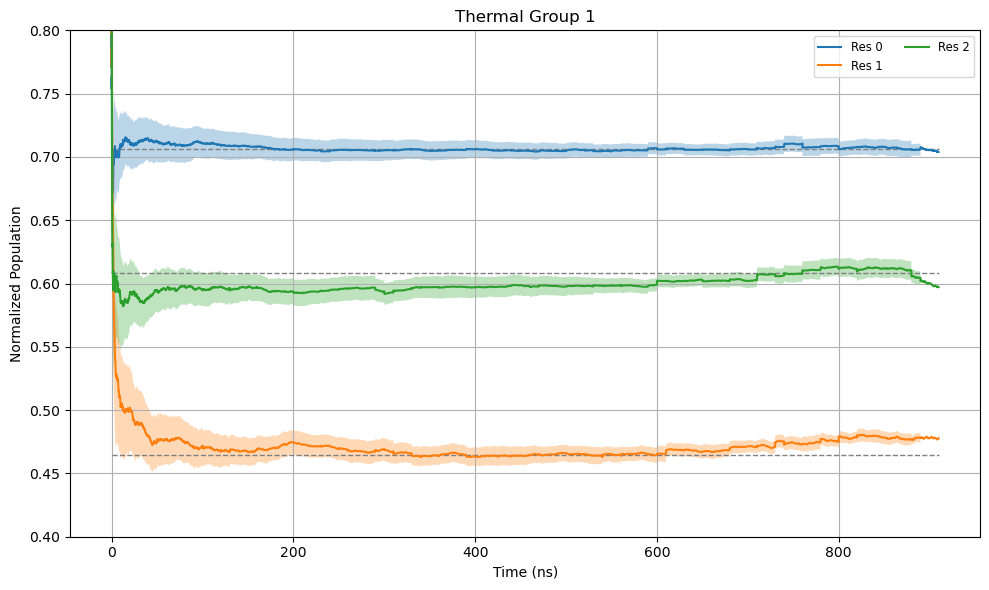

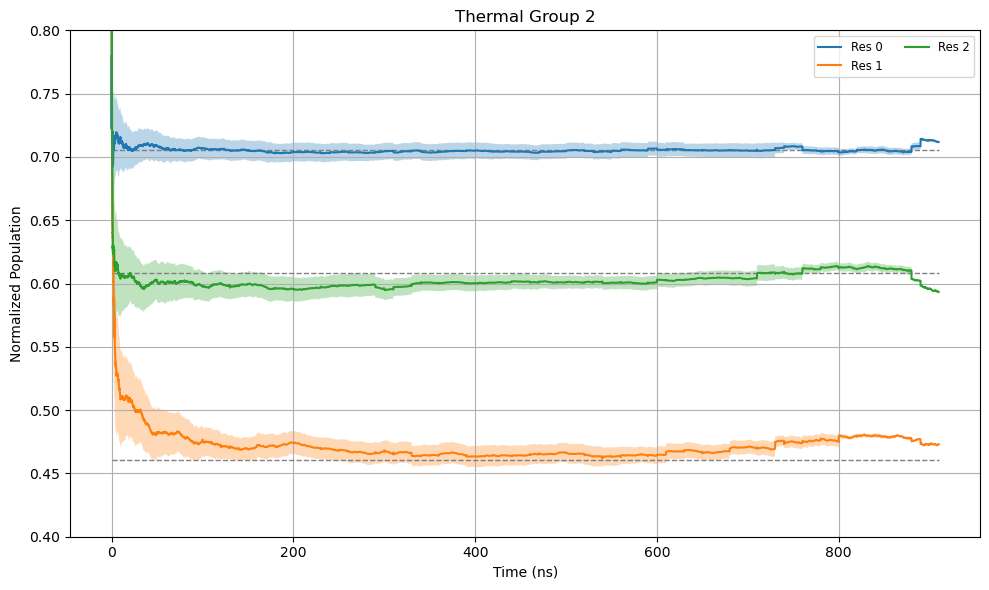

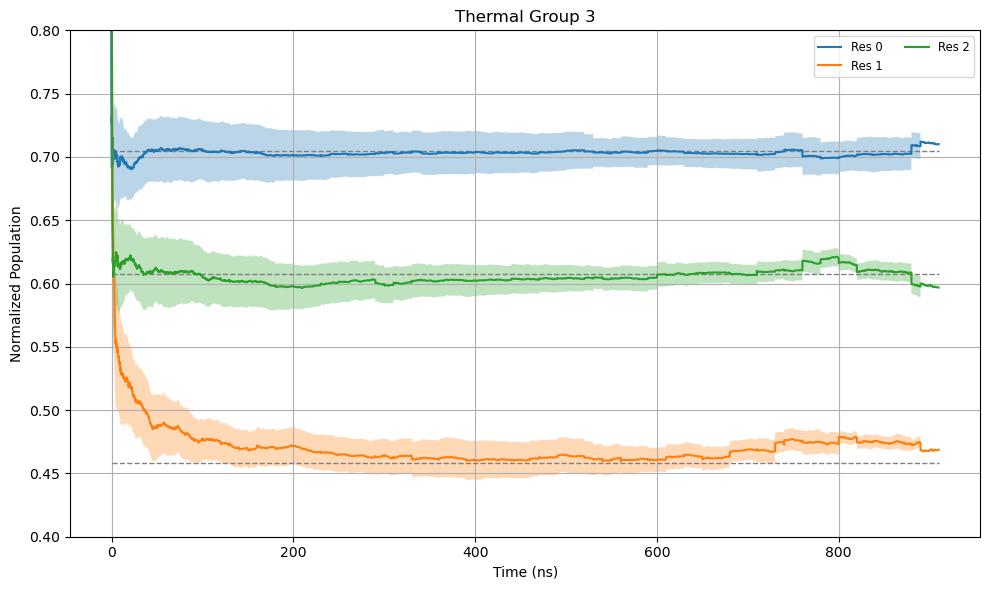

In [72]:
dt_in_ns = 0.01  # 10 ps = 0.01 ns
time = np.arange(reshaped_mean.shape[3]) #(3, 4, 2, x)
time_ns = time * dt_in_ns  # Convert to ns

for thermal in range(thermal_num):
    plt.figure(figsize=(10, 6))

    for res in range(res_num):
        mean = reshaped_mean[res, thermal, 1,  :] # Only plot trans 
        rmsd = reshaped_std[res, thermal, 1,  :] # Only plot trans 
        ref = trans_refer[thermal, res]

        plt.plot(time_ns, mean, label=f'Res {res}')
        plt.fill_between(time_ns, mean - rmsd, mean + rmsd, alpha=0.3)
        plt.hlines(y=ref, xmin=time_ns[0], xmax=time_ns[-1],
                   colors='gray', linestyles='--', linewidth=1)

    # Optional: set y-axis limits if you want consistency across plots
    plt.ylim(0.4, 0.8)

    plt.xlabel("Time (ns)")
    plt.ylabel("Normalized Population")
    plt.title(f"Thermal Group {thermal}")
    plt.legend(ncol=2, fontsize='small')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


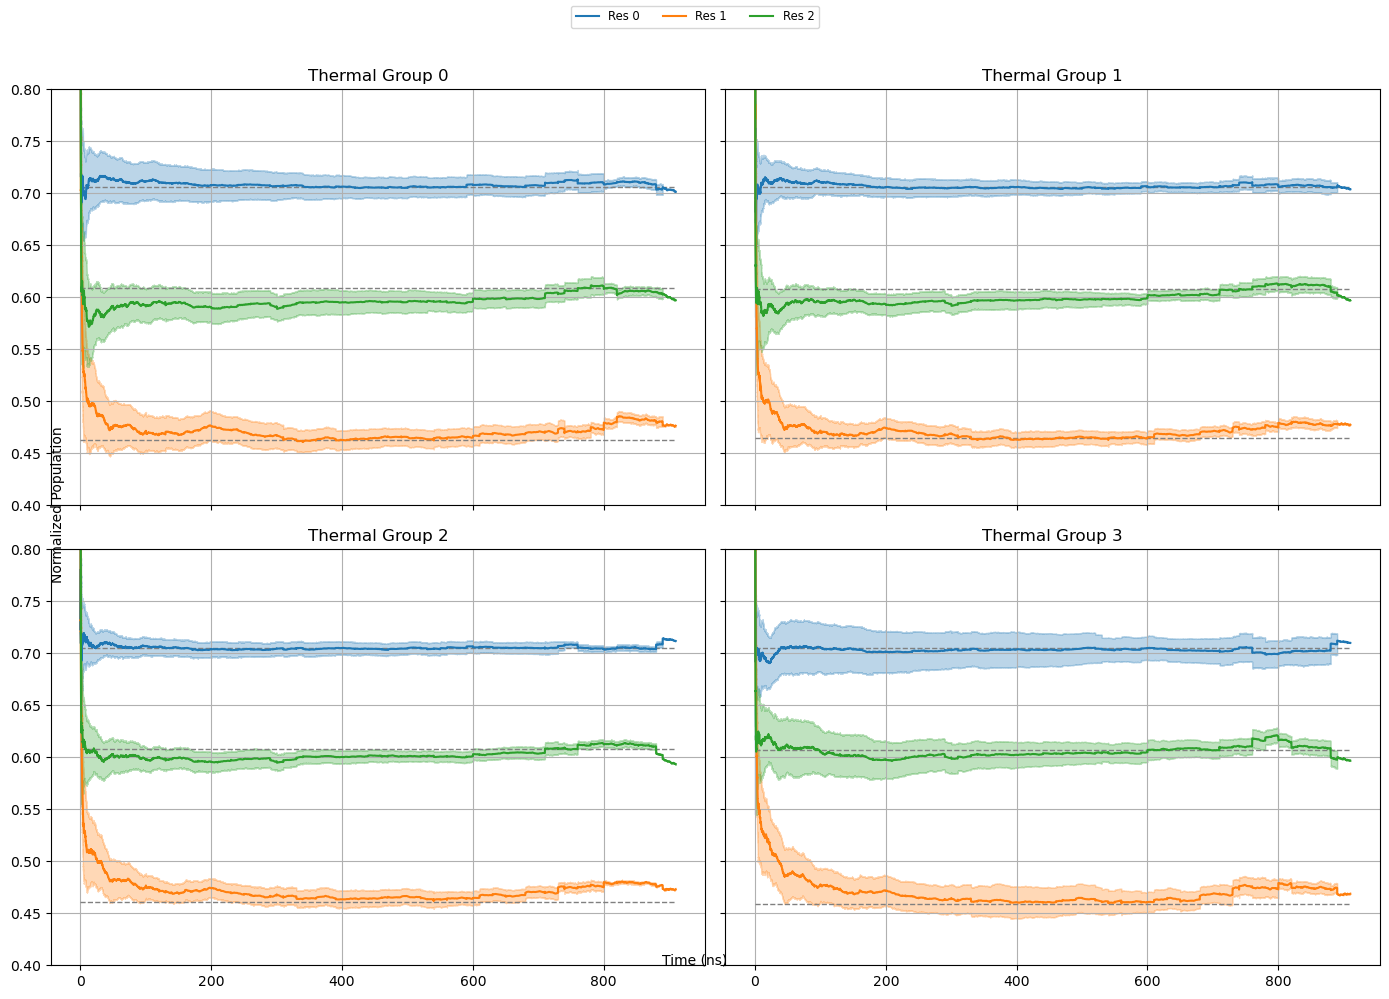

In [73]:
dt_in_ns = 0.01  # 10 ps = 0.01 ns
thermal_num = 4
res_num = reshaped_mean.shape[0]
time = np.arange(reshaped_mean.shape[3])
time_ns = time * dt_in_ns  # Convert to ns

# Set up 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)

for thermal in range(thermal_num):
    row = thermal // 2
    col = thermal % 2
    ax = axes[row, col]

    for res in range(res_num):
        mean = reshaped_mean[res, thermal, 1, :]  # conformer index 1 = trans
        rmsd = reshaped_std[res, thermal, 1, :]
        ref = trans_refer[thermal, res]

        line, = ax.plot(time_ns, mean, label=f'Res {res}')
        ax.fill_between(time_ns, mean - rmsd, mean + rmsd, alpha=0.3, color=line.get_color())
        ax.hlines(y=ref, xmin=time_ns[0], xmax=time_ns[-1],
                  colors='gray', linestyles='--', linewidth=1)

    ax.set_title(f"Thermal Group {thermal}")
    ax.set_ylim(0.4, 0.8)
    ax.grid(True)

# Shared axis labels
fig.text(0.5, 0.04, 'Time (ns)', ha='center')
fig.text(0.04, 0.5, 'Normalized Population', va='center', rotation='vertical')

# Shared legend from last subplot
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=6, fontsize='small')

fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Error Over Time 

In [74]:
## Load in the refer values calculated by MSM

df_stationary_p = pd.read_csv("autocoorel_data/trans_population_at_lagtime.csv")
#print(df_stationary_p)

    
# Pivot the DataFrame to reshape it
pivot_mean = df_stationary_p.pivot(index='state', columns='res', values='mean')
pivot_std = df_stationary_p.pivot(index='state', columns='res', values='std')

# Convert to NumPy arrays
trans_refer = pivot_mean.to_numpy()  # shape (6, 3) state, residues 
trans_refer_err = pivot_std.to_numpy()  # shape (6, 3)
trans_refer.shape

(4, 3)

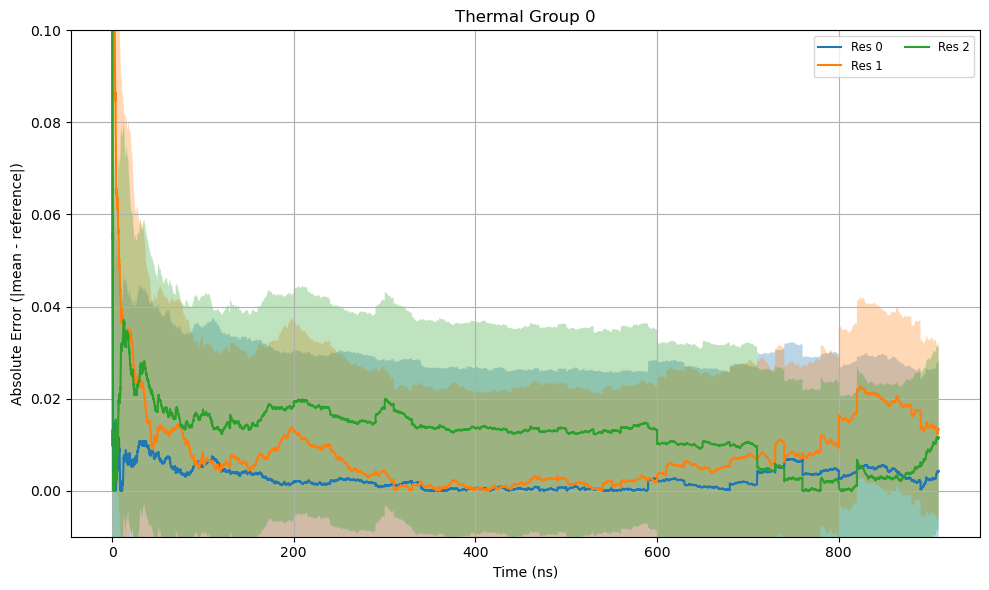

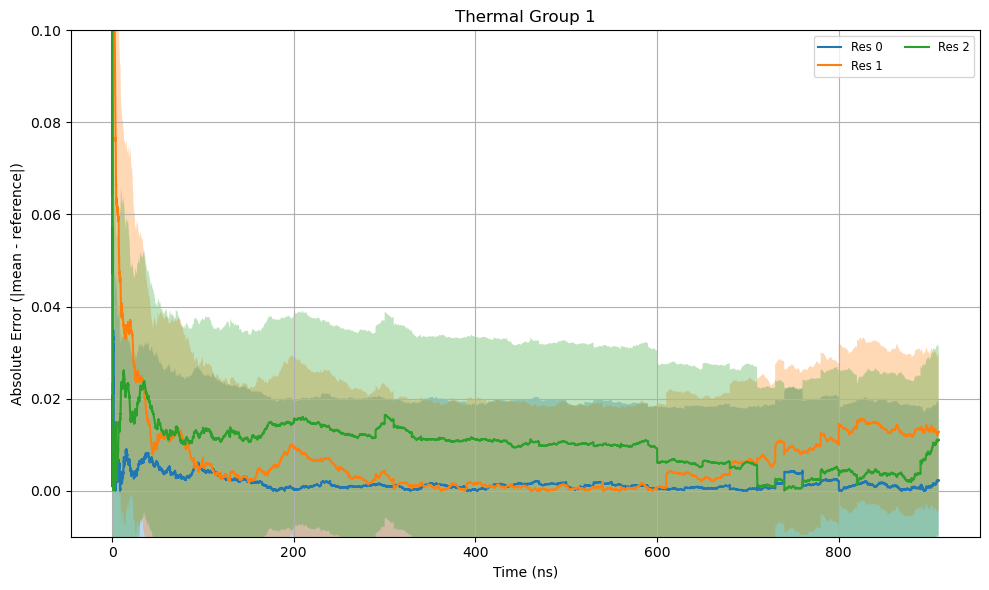

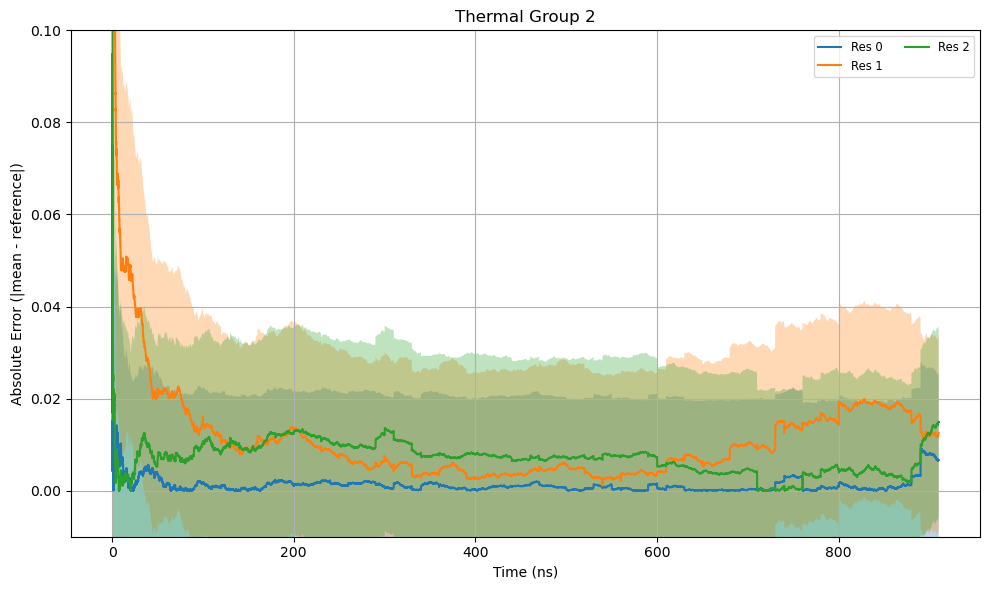

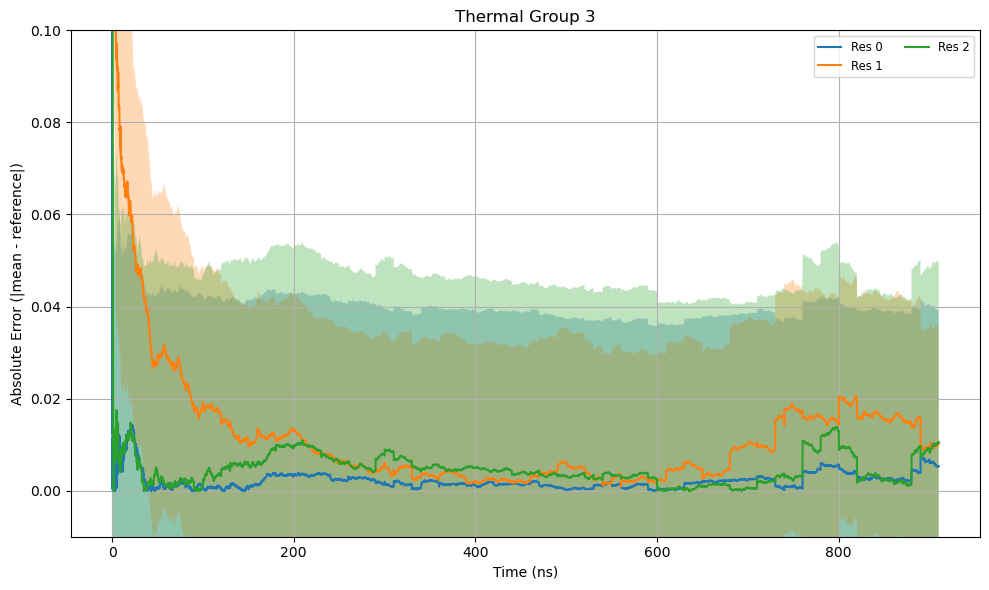

In [75]:
dt_in_ns = 0.01  # 10 ps = 0.01 ns

dt_in_ns = 0.01  # 10 ps = 0.01 ns
time = np.arange(reshaped_mean.shape[3]) #(3, 4, 2, x)
time_ns = time * dt_in_ns  # Convert to ns

errors_all = []
errors_err_all = []

for thermal in range(thermal_num):
    errors = []
    errors_err = []
    plt.figure(figsize=(10, 6))

    for res in range(res_num):
        mean = reshaped_mean[res, thermal, 1, :]  # conformer index 1 = trans
        rmsd = reshaped_std[res, thermal, 1, :]
        ref = trans_refer[thermal, res]
        ref_err = trans_refer_err[thermal, res]

        error = np.abs(mean - ref)
        error_err = np.sqrt(np.clip(ref_err ** 2 + rmsd ** 2, 0, None))

        errors.append(error)
        errors_err.append(error_err)
        
        plt.plot(time_ns, error, label=f'Res {res}')
        plt.fill_between(time_ns, error - error_err, error + error_err, alpha=0.3)

    errors_all.append(errors)
    errors_err_all.append(errors_err)
    plt.ylim(-0.01, 0.1)  # Adjust if needed
    plt.xlabel("Time (ns)")
    plt.ylabel("Absolute Error (|mean - reference|)")
    plt.title(f"Thermal Group {thermal}")
    plt.legend(ncol=2, fontsize='small')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


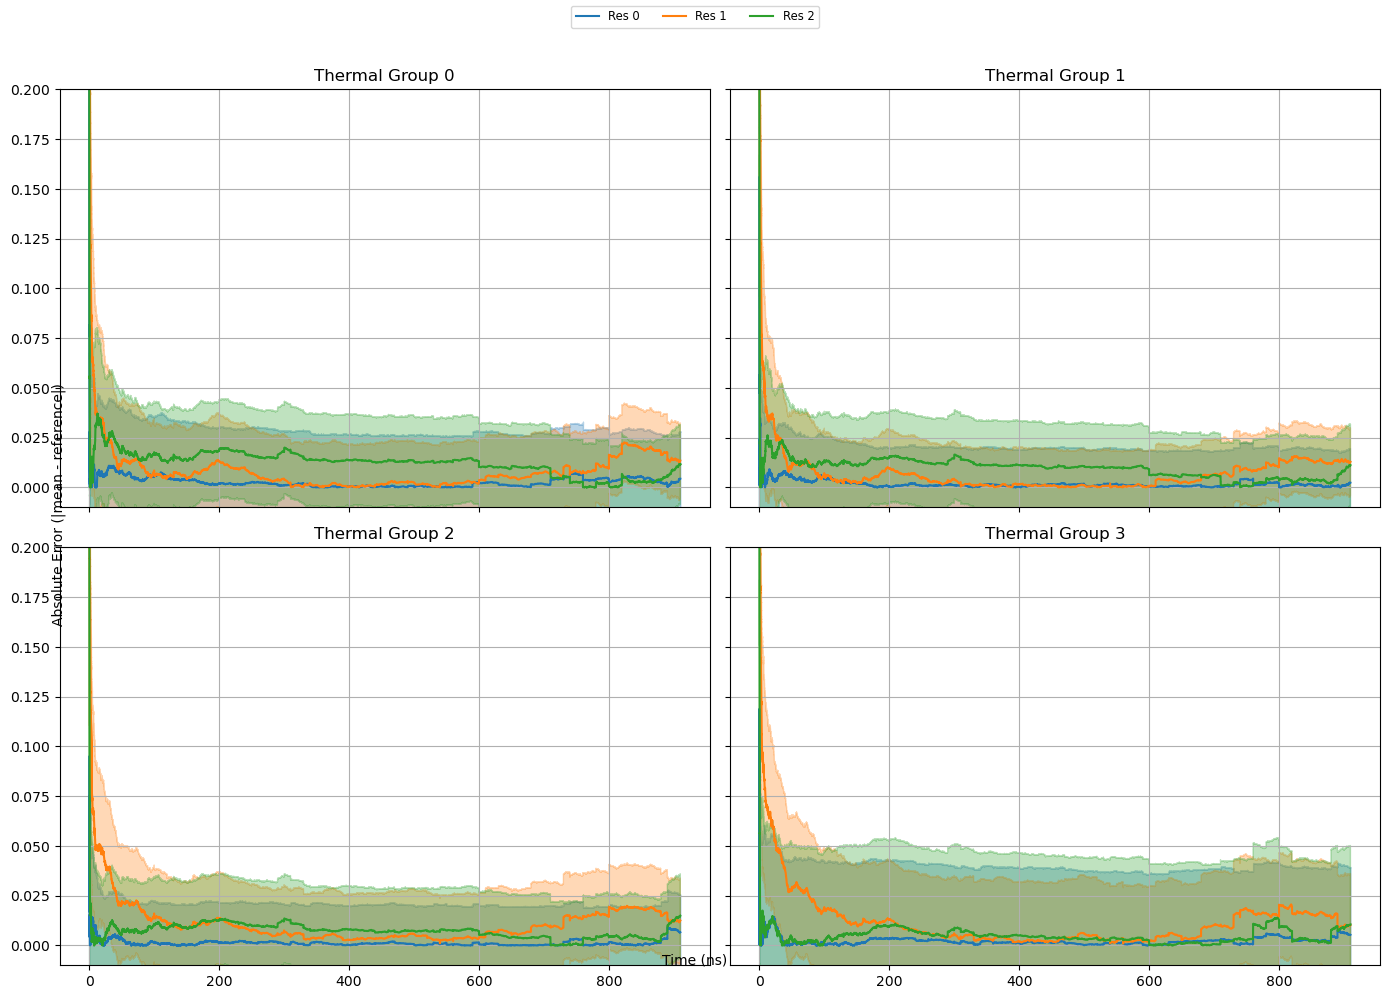

In [77]:
dt_in_ns = 0.01  # 10 ps = 0.01 ns
thermal_num = 4
res_num = reshaped_mean.shape[0]

time = np.arange(reshaped_mean.shape[3])  # Shape: (res, thermal, conform, time)
time_ns = time * dt_in_ns

errors_all = []
errors_err_all = []

fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)

for thermal in range(thermal_num):
    row = thermal // 2
    col = thermal % 2
    ax = axes[row, col]

    errors = []
    errors_err = []

    for res in range(res_num):
        mean = reshaped_mean[res, thermal, 1, :]  # conformer index 1 = trans
        rmsd = reshaped_std[res, thermal, 1, :]
        ref = trans_refer[thermal, res]
        ref_err = trans_refer_err[thermal, res]

        error = np.abs(mean - ref)
        error_err = np.sqrt(np.clip(ref_err ** 2 + rmsd ** 2, 0, None))

        errors.append(error)
        errors_err.append(error_err)

        line, = ax.plot(time_ns, error, label=f'Res {res}')
        ax.fill_between(time_ns, error - error_err, error + error_err,
                        alpha=0.3, color=line.get_color())

    errors_all.append(errors)
    errors_err_all.append(errors_err)

    ax.set_title(f"Thermal Group {thermal}")
    ax.set_ylim(-0.01, 0.2)
    ax.grid(True)

# Shared axis labels
fig.text(0.5, 0.04, 'Time (ns)', ha='center')
fig.text(0.04, 0.5, 'Absolute Error (|mean - reference|)', va='center', rotation='vertical')

# Shared legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=6, fontsize='small')

fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [78]:
errors_all = np.array(errors_all)
errors_err_all = np.array(errors_err_all)
print(errors_all.shape)
print(errors_err_all.shape)
errors_result = [errors_all, errors_err_all]

os.makedirs('population_data', exist_ok=True)

data_instance = Data(errors_result)
data_instance.save("population_data/error_res.pkl")

(4, 3, 91002)
(4, 3, 91002)
